# Coursework for Artificial Intelligence M COMPSCI5087 2024-2025

## Imports

In [2]:
import os, sys
import networkx as nx
import json
import numpy as np

from matplotlib import use
import matplotlib.pyplot as plt
import ipywidgets as widgets
use("Agg")

import warnings
warnings.filterwarnings("ignore")

import maze as m
import solvers as solv

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

%load_ext autoreload
%autoreload 2

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


## Parameters

In [3]:
# N = [11] # Growing number of tiles on the side
N = [11, 15, 21, 25, 31] # Growing number of tiles on the side
M = 2 # Fixed number of wormholes

n_repetitions = 20
folder = "N04"

## Setup

In [9]:
results_dir = os.path.join("solved", folder)
if not os.path.isdir(results_dir): os.mkdir(results_dir)

filepath = lambda N, label, k, extension : os.path.join(results_dir, f"{label}_{N:02.0f}_{k:02.0f}.{extension}")

## Problem Description

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are one-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), but from (0,7) you can't go to (2,1).

Problem details
- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

Important properties
- Branching factor? $b=5$, due to the 5 possible actions; could be optimistically lowered to 3 for most cases, since most tiles are only connected to 2 neighbours.
- Depth of the solution? $d\leq 4(N-2)$ with no teleportation links, effectively less with teleportation links

## Solver description

The **heuristic function** $h$ is an arbitrary, non-negative, problem-specific function with one constrain: if $n$ is a goal node, then $h(n)=0$.

_The tree-search version of A-star is optimal if the heuristic function is **admissible**_. 

A heuristic function is admissible if it never overestimates the cost to reach a goal, i.e. an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is. _The most optimistic agent going down a wormhole will always assume that a wormhole can take you right to the exit._

_The graph-search version of A-star is optimal if the heuristic function is **consistent**_. 

A heuristic function is consistent if, for every node $n$ and every successor $n'$ of $n$ generated by any action $a$, the estimated cost of reaching the goal from $n$ is no greater than the step cost of getting to $n'$ plus the estimated cost of reaching the goal from $n'$:

$h(n) \leq c(n,a,n') + h(n')$

This is a form of the general triangle inequality. 

"For an admissible heuristic, the inequality makes perfect sense: if there were a route from $n$ to $G_n$ via $n'$ that was cheaper than $h(n)$, that would violate the property that $h()n)$is a lower bound on the cost to reach $G_n$" (Russel, S, & Norvig, P.: _Artificial Intelligence: A Modern Approach_, 3rd edition, Pearson Education, 2010, USA)

If $h$ is consistent, then the values of $f(n)$ along any path are nondecreasing.

_Unfortunetely, my heuristic function is **not consistent nor admissible**_

_The reason why I still chose A-star is because it strikes a good complexity balance, most probably reaching a good solution with less iterations that uniformed search methods such as DFS and BFS.

## Experiment

In [4]:
n = N[0]
k = 0

problem_branching_factors = []
problem_n_nodes = []

solution_n_steps = []
# solution_paths = []
solution_depths = []
solution_n_frontier = []
solution_n_explored = []

In [5]:
for n in N:

    problem_branching_factors.append([])
    problem_n_nodes.append([])

    solution_n_steps.append([])
    # solution_paths.append([])
    solution_depths.append([])
    solution_n_frontier.append([])
    solution_n_explored.append([])

    for k in range(n_repetitions):

        print(f"> Maze size {n} > Repetition {k}")

        maze_problem = m.wormholes_maze_problem(n, M, show_plots=True)
        plt.savefig(filepath(n, "maze", k, "png"))
        plt.close()

        branching_factor = max([len(v) for (k,v) in maze_problem.graph.graph_dict.items()])
        problem_branching_factors[-1].append(branching_factor)
        problem_n_nodes[-1].append( len(maze_problem.graph.locations) )

        n_steps, solution_path, all_node_colors = solv.wormholes_maze_A_star_solver(maze_problem, verbose=False)

        print(f"Solved in {n_steps} iterations")

        solution_n_steps[-1].append(n_steps)
        # solution_paths[-1].append([node.state for node in solution_path])
        solution_depths[-1].append(len(solution_path))

        with open(filepath(n, "path", k, "json"), 'w', encoding='utf-8') as f:
            json.dump(dict(solution_path=[node.state for node in solution_path]), f, 
                      ensure_ascii=False, indent=4)
            
        print("Saved solution path")

        n_frontier = sum([v=="orange" for v in all_node_colors[-1].values()])
        n_explored = sum([v in ["limegreen","gray"] for v in all_node_colors[-1].values()])
        solution_n_frontier[-1].append(n_frontier)
        solution_n_explored[-1].append(n_explored)
        
        print("Added all results to lists")

        m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], n_steps)
        fig = plt.savefig(filepath(n, "solution", k, "png"))
        plt.close(fig)

        print("Plotted")

> Maze size 11 > Repetition 0
Solved in 134 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 1
Solved in 55 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 2
Solved in 150 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 3
Solved in 74 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 4
Solved in 88 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 5
Solved in 80 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 6
Solved in 76 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 7
Solved in 55 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 > Repetition 8
Solved in 122 iterations
Saved solution path
Added all results to lists
Plotted
> Maze size 11 >

In [6]:
data = dict(problem_branching_factors=problem_branching_factors,
            problem_n_nodes=problem_n_nodes,
            solution_n_steps=solution_n_steps,
            # solution_paths=solution_paths,
            solution_depths=solution_depths,
            solution_n_frontier=solution_n_frontier,
            solution_n_explored=solution_n_explored)

In [7]:
data

{'problem_branching_factors': [[4,
   4,
   3,
   5,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4],
  [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5],
  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4],
  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4]],
 'problem_n_nodes': [[51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51,
   51],
  [99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99,
   99],
  [201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201,
   201],
  [289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   289,
   

In [8]:
with open(os.path.join(results_dir, 'data.json'), 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

## Analysis

In [11]:
n_steps_mean = np.mean(solution_n_steps, axis=1)
n_steps_std = np.std(solution_n_steps, axis=1)

In [12]:
n_steps_mean

array([ 81.5 , 138.15, 228.1 , 289.7 , 449.9 ])

In [13]:
n_steps_std / np.sqrt(n_repetitions)

array([ 7.01801254,  9.83241451, 19.34035936, 27.02694026, 38.19698287])

### Results Analysis

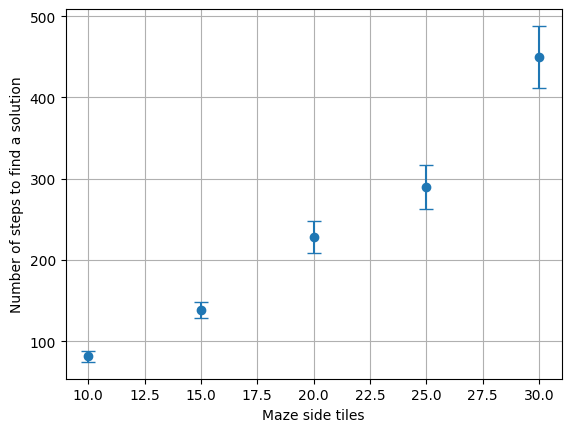

In [15]:
plot_N = [10, 15, 20, 25, 30]

# use("ipympl")
%matplotlib inline
plt.errorbar(plot_N, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", linestyle="none", capsize=5)
plt.xlabel("Maze side tiles")
plt.ylabel("Number of steps to find a solution")
plt.grid()

plt.savefig(os.path.join(results_dir, "data.png"))

In [16]:
depths_mean = np.mean(solution_depths, axis=1)
depths_std = np.std(solution_depths, axis=1)

In [17]:
depths_mean

array([14.8 , 23.6 , 34.05, 37.2 , 51.65])

In [19]:
depths_std / np.sqrt(n_repetitions)

array([0.90166513, 1.14324101, 1.4619764 , 2.03174802, 1.89641108])

### Other data

In [ ]:
series = "N04"

In [ ]:
solution_n_steps = []
solution_depths = []
results_dir = os.path.join("solved", series)
results_filepath = os.path.join(results_dir, "data.json")
# with open(os.path.join(results_dir, 'data.json'), 'w', encoding='utf-8') as f:
    # json.dump(data, f, ensure_ascii=False, indent=4)
with open(os.path.join(results_dir, 'data.json'), 'r') as file:
    data = json.load(file)
    solution_n_steps = data["solution_n_steps"]
    solution_depths = data["solution_depths"]
solution_n_steps = np.array(solution_n_steps)
solution_depths = np.array(solution_depths)

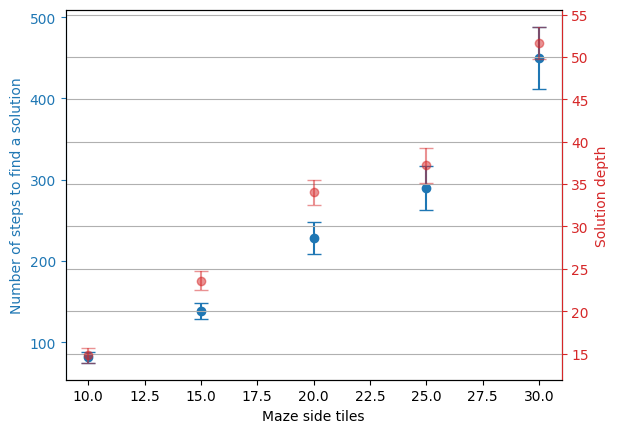

In [26]:
# use("ipympl")
%matplotlib inline
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)

ax.errorbar(plot_N, n_steps_mean, n_steps_std / np.sqrt(n_repetitions), marker="o", color="C0", linestyle="none", capsize=5)
ax2.errorbar(plot_N, depths_mean, depths_std / np.sqrt(n_repetitions), marker="o", color="C3", linestyle="none", alpha=0.5, capsize=5)
ax.set_xlabel("Maze side tiles")
ax.set_ylabel("Number of steps to find a solution")
ax2.set_ylabel("Solution depth")
ax2.grid()

ax.yaxis.label.set_color('C0')        #setting up X-axis label color to yellow
ax2.yaxis.label.set_color('C3')          #setting up Y-axis label color to blue

ax.tick_params(axis='y', colors='C0')    #setting up X-axis tick color to red
ax2.tick_params(axis='y', colors='C3')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('C0')        # setting up Y-axis tick color to red
ax2.spines['right'].set_color('C3')         #setting up above X-axis tick color to red

plt.savefig(os.path.join("solved", "data5.png"))